# Введение

## Какой кейс решаем?
Представьте, что вы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

## Описание полей
* hotel_address — адрес отеля;
* review_date — дата, когда рецензент разместил соответствующий отзыв;
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля;
* reviewer_nationality — страна рецензента;
* negative_review — отрицательный отзыв, который рецензент дал отелю;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
* positive_review — положительный отзыв, который рецензент дал отелю;
* review_total_positive_word_counts — общее количество слов в положительном отзыве.
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* tags — теги, которые рецензент дал отелю;
* days_since_review — количество дней между датой проверки и датой очистки;
* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat — географическая широта отеля;
* lng — географическая долгота отеля.


# Загрузка и анализ данных
## Импорт библиотек

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# импортируем библиотеку для геокодирования 
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Для кодирования признаков
import category_encoders as ce

!pip install twython
from twython import Twython

# расчет скоринга на основе текста отзыва
import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon', quiet=True)
nltk.download('popular', quiet=True)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


## Конфигурация и задание констант

In [2]:
# Фиксируем начальное состояние генератора случайных чисе RANDOM_SEED, чтобы эксперимент были воспроизводим! 
RANDOM_SEED = 42

# Директория размещения файлов
DATA_DIR = '/kaggle/input/sf-booking/'

# Фиксируем версию пакетов, чтобы эксперимент были воспроизводим! 
!pip freeze > requirements.txt

## Загрузка и первичное изучение данных

In [3]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [5]:
df_train.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [7]:
df_test.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520


In [8]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [9]:
sample_submission.head(3)

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688


## Визуализация корреляции между числовыми признаками

In [ ]:
corr_view_data = df_train.corr(method = 'spearman', numeric_only = True)
plt.rcParams['figure.figsize'] = (15,10)
heatmap = sns.heatmap(corr_view_data, annot = True, vmin=-1, vmax=1, center= 0)

Наибольшее значение статистическая взаимосвязь reviewer_score наблюдается между признаками review_total_negative_word_counts, review_total_positive_word_counts и average_score     

### Иследуем влияние review_total_negative_word_counts

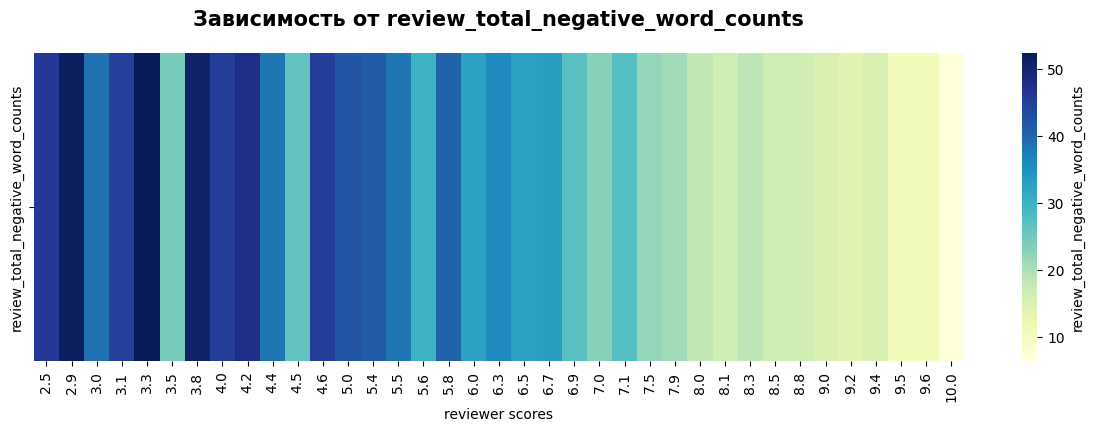

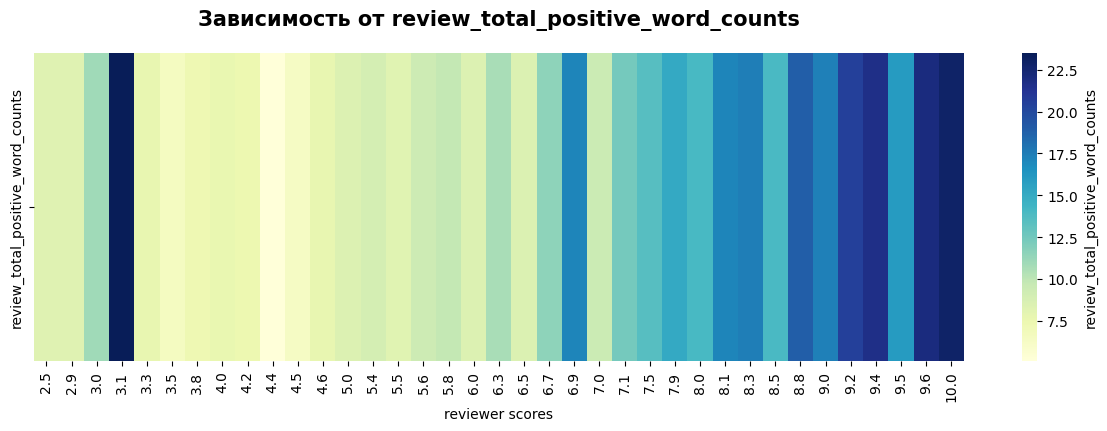

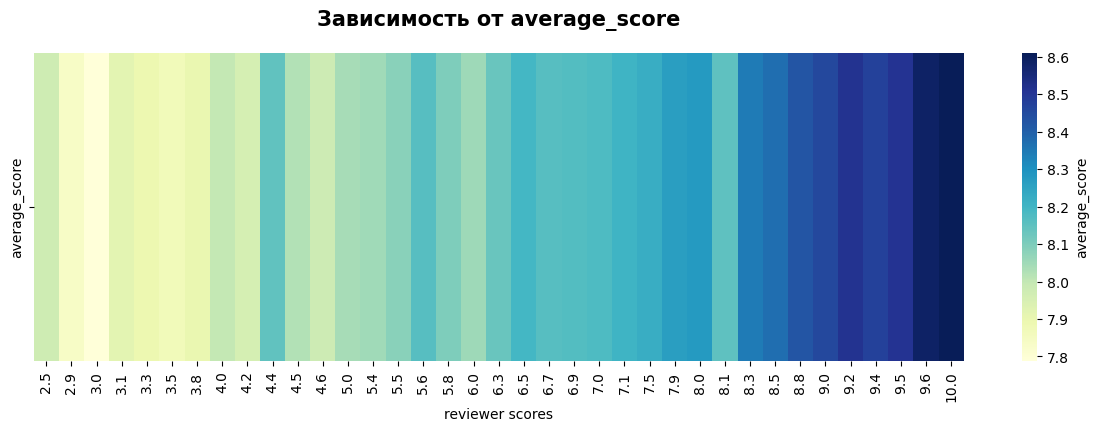

In [11]:
def creating_heatmap(data, values):
    """Функция создания heatmap на определенном датасет и по определенному признаку
    Args:
        Наименование признака (str)
        Иследуемый датасет (name of column (str))
    Returns:
        heatmap
    """
    
    pivot_table = data.pivot_table(
    values=values, columns='reviewer_score')
    pivot_table.columns = pivot_table.columns.astype('string')
    fig, ax = plt.subplots(figsize=(15,4))    
    heatmap = sns.heatmap(data=pivot_table, cmap='YlGnBu', 
                          cbar_kws={'label': values})
    heatmap.set_title('Зависимость от ' + values,
                      fontsize=15, fontweight='bold', pad=20);
    heatmap.set_xlabel('reviewer scores');
    
    
heatmap_review_total_negative_word_counts = creating_heatmap(df_train,'review_total_negative_word_counts')
heatmap_review_total_positive_word_counts = creating_heatmap(df_train,'review_total_positive_word_counts')
heatmap_average_score = creating_heatmap(df_train,'average_score')

In [12]:
# Проверяем количество выбивающихся записей
print(df_train[df_train["reviewer_score"]==3.0].shape[0])
print(df_train[df_train["reviewer_score"]==3.1].shape[0])
print(df_train[df_train["reviewer_score"]==3.5].shape[0])
print(df_train[df_train["reviewer_score"]==4.4].shape[0])
print(df_train[df_train["reviewer_score"]==4.5].shape[0])
print(df_train[df_train["reviewer_score"]==5.6].shape[0])
print(df_train[df_train["reviewer_score"]==6.9].shape[0])

25
6
61
9
97
13
23


In [13]:
df_train = df_train[df_train["reviewer_score"]!=3.0]
df_train = df_train[df_train["reviewer_score"]!=3.1]
df_train = df_train[df_train["reviewer_score"]!=3.5]
df_train = df_train[df_train["reviewer_score"]!=4.4]
df_train = df_train[df_train["reviewer_score"]!=4.5]
df_train = df_train[df_train["reviewer_score"]!=5.6]
df_train = df_train[df_train["reviewer_score"]!=6.9]

## Объединяем трейн и тест в один датасет

In [14]:
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями
data = pd.concat([df_test, df_train], ignore_index=True) # Объединяем трейн и тест в один датасет

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515504 entries, 0 to 515503
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515504 non-null  object 
 1   additional_number_of_scoring                515504 non-null  int64  
 2   review_date                                 515504 non-null  object 
 3   average_score                               515504 non-null  float64
 4   hotel_name                                  515504 non-null  object 
 5   reviewer_nationality                        515504 non-null  object 
 6   negative_review                             515504 non-null  object 
 7   review_total_negative_word_counts           515504 non-null  int64  
 8   total_number_of_reviews                     515504 non-null  int64  
 9   positive_review                             515504 non-null  object 
 

In [16]:
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0


# Очистка данных
##  Неинформативные признаки
Получение списка неинформативных признаков, у которых доля от общих данных, которую занимает каждое уникальное значение в признаке, более 95%

In [17]:
def get_nunique_ratio(data):
  #список неинформативных признаков
  low_information_cols = [] 

  #цикл по всем столбцам
  for col in data.columns:
      #наибольшая относительная частота в признаке
      top_freq = data[col].value_counts(normalize=True).max()
      #доля уникальных значений от размера признака
      nunique_ratio = data[col].nunique() / data[col].count()
      # сравниваем наибольшую частоту с порогом
      if top_freq > 0.95:
          low_information_cols.append(col)
          print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
      # сравниваем долю уникальных значений с порогом
      if nunique_ratio > 0.95:
          low_information_cols.append(col)
          print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

In [18]:
get_nunique_ratio(data)

## Выбросы 
Ислед оценку, которую рецензент поставил отелю на основе своего опыт **'reviewer_score'**, т.к. удаление строк тестовых данных приведет к ошибке построения модели из-за несовпадения количества записей

In [19]:
def outliers_z_score_mod(data, feature, left=3, right=3, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = (data[feature])
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [20]:
# Определяем выбросы

outliers, cleaned = outliers_z_score_mod(
    data = data, feature = 'reviewer_score', log_scale=True, left=3, right=3)
print(f'Число выбросов по методу Z-ОТКЛОНЕНИЙ: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Z-ОТКЛОНЕНИЙ: 0
Результирующее число записей: 515504


## Пропущенные значения
На основе ранее полученной информации, пропуски у нас в признаках:
* lat — географическая широта  отеля (заполнено 512470 из 515738);
* lng — географическая долгота отеля (заполнено 512470 из 515738).


In [21]:
# Отбираем строки с пропусками и сохраняем в отдельный dataframe
rows_with_missing_lat = data[data['lat'].isnull() | (data['lat'] == '')]
# Оставляем только те признаки, что нам могут понадобиться для поиска координат
rows_with_missing_lat = rows_with_missing_lat[['hotel_name', 'lat', 'lng', 'hotel_address']]
# Удаляем дубликаты отелей на основе уникальности адреса, формируя справочник отелей, у которых не заданы координаты
rows_with_missing_lat = rows_with_missing_lat.drop_duplicates(subset='hotel_address')

In [22]:
# Инструмент для поиска данных OSM по имени и адресу
geolocator = Nominatim(user_agent="for_kaggle_test")

# Заполняем отсутствующие координаты
for i, row in rows_with_missing_lat.iterrows():
    hotel_address = row['hotel_address']
    location = geolocator.geocode(hotel_address, timeout=None)
    # Если по адресу не нашли, то ищем по индексу
    if not location:
        index = ' '.join(hotel_address.split()[-3:])
        location = geolocator.geocode(index, timeout=None)   
    if location:
        rows_with_missing_lat.loc[i, 'lat'] = location.latitude
        rows_with_missing_lat.loc[i, 'lng'] = location.longitude



In [23]:
# Переносим найденные координаты из справочника в наш датасет
for i, address in enumerate(data['hotel_address']):
    if pd.isna(data.at[i, 'lat']) or data.at[i, 'lat'] == '':
        matching_address = rows_with_missing_lat.loc[rows_with_missing_lat['hotel_address'] == address]
        if not matching_address.empty:
            data.at[i, 'lat'] = matching_address['lat'].values[0]
            data.at[i, 'lng'] = matching_address['lng'].values[0]

# Статистический анализ данных

## Создание новых признаков
### Иследуем признак review_date — дата, когда рецензент разместил соответствующий отзыв и попробуем выделить дополнительные числовые признаки

In [24]:
# Преобразуем в datetime
data['review_date'] = pd.to_datetime(data['review_date'])

In [25]:
# Выделяем такие признаки, как год, месяц и день недели
data['review_year'] = pd.to_datetime(data['review_date']).dt.year
data['review_month'] = pd.to_datetime(data['review_date']).dt.month
data['review_day_of_week'] = pd.to_datetime(data['review_date']).dt.day_of_week
data['review_year_month'] = data['review_year'] * 100 + data['review_month']
# Определение высокого сезона
high_season_months = [1, 5, 6, 7, 8, 9]
# Создание признака 'high_season'
data['high_season'] = (data['review_month'].isin(high_season_months)).astype(int)

In [26]:
# Определяем дату первой публикации отзыва
min_review_dates = data.groupby('hotel_name')['review_date'].min()
# Определяем дату крайней публикации отзыва
max_review_dates = data.groupby('hotel_name')['review_date'].max()

# Создаем в датасете признаки с начальной и крайней публикацией отзыва
data['min_review_dates'] = data['hotel_name'].map(min_review_dates)
data['max_review_dates'] = data['hotel_name'].map(max_review_dates)

# Создаем в датасете признак c количеством дней от саммой ранней публикации до даты текущей публикации
data['days_from_first_review_date'] = (data['review_date'] - data['min_review_dates']).dt.days

# Создаем в датасете признак c количеством дней от саммой ранней публикации до самой крайней публикации
data['days_from_max_min_review_date'] = (data['max_review_dates'] - data['min_review_dates']).dt.days

### Иследуем признак negative_review и positive_review, попробуем выделить дополнительные числовые признаки

In [27]:
# Приводим к нижнему регистру для последующей обработки
data['negative_review'] = data['negative_review'].str.lower()
data['positive_review'] = data['positive_review'].str.lower()
data['reviewer_nationality'] = data['reviewer_nationality'].str.strip()

In [28]:
# Убираем слова, которые могут повлиять на расчет рейтинга
data['negative_review'] = data['negative_review'].str.replace('no comment', '')
data['negative_review'] = data['negative_review'].str.replace('no negative', '')
data['negative_review'] = data['negative_review'].str.replace('nothing negativee', '')
data['negative_review'] = data['negative_review'].str.replace(' nothing', '')
data['negative_review'] = data['negative_review'].str.replace('nothing', '')
data['negative_review'] = data['negative_review'].str.replace('nothing ', '')
data['negative_review'] = data['negative_review'].str.replace('not negative', '')
data['negative_review'] = data['negative_review'].str.replace('do not make it negative', '')
data['negative_review'] = data['negative_review'].str.replace('no comment', '')

In [29]:
# Убираем слова, которые могут повлиять на расчет рейтинга
data['positive_review'] = data['positive_review'].str.replace(' nothing', '')
data['positive_review'] = data['positive_review'].str.replace('nothing', '')
data['positive_review'] = data['positive_review'].str.replace('nothing ', '')
data['positive_review'] = data['positive_review'].str.replace('no positive', '')

In [30]:
# Скоринг негативного отзыва

# Создаем экземпляр анализатора
sia = SentimentIntensityAnalyzer()

# Оцениваем текст отзывов и записываем результат в новый признак
data['negative_review_score'] = data['negative_review'].apply(lambda x: sia.polarity_scores(x)['neg'])

In [31]:
# Скоринг позитивного отзыва

# Создаем экземпляр анализатора
sia = SentimentIntensityAnalyzer()

# Оцениваем текст отзывов и записываем результат в новый признак
data['positive_review_score'] = data['positive_review'].apply(lambda x: sia.polarity_scores(x)['pos'])

In [32]:
# отношение негативного к позитивному
data['ratio_review_score'] = data.apply(lambda row: (row['negative_review_score'] + 0.001) / (row['positive_review_score']+ 0.001), axis=1)

Просмотрев посчитанные значения, возникает много вопросов к библиотеке, расчитывающей негатив и позитив sia.polarity_scores(x)
оставил, т.к. есть улучшение предсказания

In [33]:
# Создание нового признака 'review_count' с количеством отзывов
data['review_count'] = data.groupby('hotel_name')['review_date'].rank(method='dense', ascending=True).astype(int)


In [34]:
# Создаем новые признаки на основе анализа слов в негативном отзыве
data['negative_review_room'] = data['negative_review'].str.contains(' room').astype(int)
data['negative_review_very'] = data['negative_review'].str.contains(' very').astype(int)
data['negative_review_breakfast'] = data['negative_review'].str.contains('breakfast').astype(int)
data['negative_review_small'] = data['negative_review'].str.contains('small').astype(int)
data['negative_review_staff'] = data['negative_review'].str.contains('staff').astype(int)
data['negative_review_bed'] = data['negative_review'].str.contains(' bed').astype(int)
data['negative_review_bathroom'] = data['negative_review'].str.contains(' bathroom').astype(int)

In [35]:
# Создаем новые признаки на основе анализа слов в позитивном отзыве
data['positive_review_staff'] = data['positive_review'].str.contains('staff ').astype(int)
data['positive_review_very'] = data['positive_review'].str.contains('very ').astype(int)
data['positive_review_location'] = data['positive_review'].str.contains(' location').astype(int)
data['positive_review_room'] = data['positive_review'].str.contains(' room').astype(int)
data['positive_review_good'] = data['positive_review'].str.contains('good ').astype(int)
data['positive_review_great'] = data['positive_review'].str.contains('great ').astype(int)
data['positive_review_friendly'] = data['positive_review'].str.contains('friendly').astype(int)
data['positive_review_breakfast'] = data['positive_review'].str.contains('breakfast').astype(int)
data['positive_review_helpful'] = data['positive_review'].str.contains('helpful').astype(int)
data['positive_review_clean'] = data['positive_review'].str.contains('clean').astype(int)
data['positive_review_excellent'] = data['positive_review'].str.contains('excellent').astype(int)
data['positive_review_comfortable'] = data['positive_review'].str.contains('comfortable').astype(int)
data['positive_review_bed'] = data['positive_review'].str.contains(' bed ').astype(int)
data['positive_review_lovely'] = data['positive_review'].str.contains('lovely').astype(int)

### Иследуем признак hotel_address и Создаем новые признаки 'country' и 'city'

In [36]:
# Создание нового признака 'country' и 'city'
data['country'] = data['hotel_address'].apply(lambda x: x.split()[-1] 
        if x.split()[-1] != 'Kingdom' 
        else ' '.join(x.split()[-2:]))

data['city'] = data.apply(lambda x: x['hotel_address'].split()[-5] 
        if x['country'] == 'United Kingdom'
        else x['hotel_address'].split()[-2], axis=1
)

In [37]:
# Информация о популярности городов для туристов
city_info = pd.DataFrame(
    [
        ['London', 10], 
        ['Barcelona', 9], 
        ['Paris', 1], 
        ['Amsterdam', 5], 
        ['Vienna', 18], 
        ['Milan', 13]
    ],     columns=['city', 'city_attractiveness_rating'])

data = data.merge(city_info, how='left', on='city')

In [38]:
# Кодируем признак city
encoder = ce.OneHotEncoder(cols=['city'])
encoder = encoder.fit_transform(data['city'])
X = encoder.rename(columns={'city_1':'London','city_2':'Paris','city_3':'Amsterdam','city_4':'Milan','city_5':'Vienna','city_6':'Barcelona'})
data = pd.concat([data, X], axis=1)

In [39]:
# Кодируем признак country
encoder = ce.OneHotEncoder(cols=['country'])
encoder = encoder.fit_transform(data['country'])
X = encoder.rename(columns={'country_1':'United Kingdom','country_2':'France','country_3':'Netherlands','country_4':'Italy','country_5':'Austria','country_6':'Spain'})
data = pd.concat([data, X], axis=1)

In [40]:
# Создание нового признака 'local_resident'
data['local_resident'] = data['reviewer_nationality'] == data['country']

# Преобразование 'local_resident' в int
data['local_resident'] = data['local_resident'].astype('int')

In [41]:
# Создаем признак, на основе страна рецензента

# Отбираем 99 уникальных значений
unique_reviewer_nationality = data['reviewer_nationality'].value_counts().nlargest(99).index

# Всем остальным проставляем 'Other'
data['reviewer_nationality_reduced'] = data['reviewer_nationality'].apply(lambda x: x if x in unique_reviewer_nationality else 'Other')

# Создание экземпляра BinaryEncoder
encoder = ce.BinaryEncoder(cols=['reviewer_nationality_reduced']) 

# Преобразование признака 'reviewer_nationality' в бинарный код
X = encoder.fit_transform(data['reviewer_nationality_reduced'])
# Объединение закодированных столбцов с исходным DataFrame
data = pd.concat([data, X], axis=1)

In [42]:
# Создание нового признака 'hotel_city_count' с количесвом отелей в городе
data['hotel_city_count'] = data.groupby('city')['hotel_name'].transform('count')

### Иследуем признак days_since_review и выделяем дни в числовой признак

In [43]:
# Создание новой колонки 'days_review' с числовым значением дней
data['days_review'] = data['days_since_review'].str.extract(r'(\d+)', expand=False).astype(int)

### На основе признаков с координатами созданим новый признак, расстояние до центра

In [44]:
# Создаем словарь
df_city = data.drop_duplicates(subset='city')
df_city = df_city[['city']]
df_city.loc[:, 'city_lng'] = np.nan
df_city.loc[:, 'city_lat'] = np.nan


In [45]:
# Инструмент для поиска данных OSM по имени и адресу
geolocator = Nominatim(user_agent="for_kaggle_test")

# Заполняем координаты по каждому городу, создаем словарь
for i, row in df_city.iterrows():
    city_address = row['city']
    location = geolocator.geocode(city_address, timeout=None)
    # Если по адресу не нашли, то ищем по индексу
    if not location:
        print(city_address) 
    if location:
        df_city.loc[i, 'city_lat'] = location.latitude
        df_city.loc[i, 'city_lng'] = location.longitude

In [46]:
# Создание словаря для быстрого поиска координат городов
city_coords = dict(zip(df_city['city'], zip(df_city['city_lat'], df_city['city_lng'])))

# Вычислить расстояние между точками и записать в новый признак
data['distance_from_center'] = data.apply(lambda row: geodesic(city_coords[row['city']], (row['lat'], row['lng'])).km, axis=1)

### Иследуем признак tags и попробуем выделить дополнительные числовые признаки

In [47]:
data['tags'] = data['tags'].str.lower()

In [48]:
# Создаем признак количество ночей на основе определеного тэга
data['nights'] = data['tags'].str.extract(r"stayed (\d+) night")
data['nights'] = data['nights'].fillna(data['nights'].dropna().astype(int).median()).astype(int)
# С числовым значением были Warnings, поэтому превратил обратно в строку :)
data['nights'] = data['nights'].astype('str')

# Кодирование признака 'nights' с помощью BinaryEncoder
encoder = ce.BinaryEncoder(cols=['nights'])
data_encoded = encoder.fit_transform(data['nights'])
data = pd.concat([data, data_encoded], axis=1)

In [49]:
# Создаем признак, определяющий, какая цель поездки
data['tag_type_trip'] = data['tags'].apply(lambda x: 'business' if 'business' in x else 'leisure')

In [50]:
# Кодирование признака 'tag_type_trip' с помощью BinaryEncoder
encoder = ce.BinaryEncoder(cols=['tag_type_trip'])
data_encoded = encoder.fit_transform(data['tag_type_trip'])
data = pd.concat([data, data_encoded], axis=1)

In [51]:
# Дабавляем признак, который говорит, что путешествовали с маленькими детьми
data['tag_children'] = data['tags'].apply(lambda x: 1 if 'young children' in x else 0)

# Дабавляем признак, который говорит, что публиковали отзыв с мобильного телефона
data['tag_mobile_device'] = data['tags'].apply(lambda x: 1 if 'mobile device' in x else 0)

# Создаем новый признак по возможности остановиться с животными
data['tag_with_pet'] = data['tags'].apply(lambda x: 1 if 'a pet' in x else 0)

In [52]:
# Создаем новый признак по типу путешествиников
def set_why_stayed(value):
    if 'group' in  value:
        return 'group'
    if 'couple' in value:
        return 'couple'  
    if 'solo' in value:
        return 'solo'
    if 'young' in value:
        return 'young'
    if 'older' in value:
        return 'older' 
    return np.nan

data['tag_who_stayed'] = data['tags'].apply(set_why_stayed)
data['tag_who_stayed'] = data['tag_who_stayed'].fillna(data['tag_who_stayed'].mode().iat[0])


In [53]:
# Кодирование признака 'tag_who_stayed' с помощью BinaryEncoder
encoder = ce.BinaryEncoder(cols=['tag_who_stayed'])
data_encoded = encoder.fit_transform(data['tag_who_stayed'])
data = pd.concat([data, data_encoded], axis=1)

In [54]:
# Создаем новый признак по количеству комнат
def set_room_number(value):
    if 'double' in value: return 'double'
    if 'twin' in value: return 'single'
    if '2 rooms' in value: return 'double'
    if 'triple' in value: return 'triple'
    if 'queen' in value: return 'queen'
    if 'king' in value: return 'king'
    if '3 rooms' in value: return 'triple'
    if 'family' in value: return 'family'
    if 'single' in value: return 'single'
    if '4 rooms' in value: return '4 rooms'
    if 'superior' in value: return 'superior'
    return np.nan

  
data['tag_room_number'] = data['tags'].apply(set_room_number)
data['tag_room_number'] = data['tag_room_number'].fillna(data['tag_room_number'].mode().iat[0])

In [55]:
# Кодирование признака 'tag_room_number' с помощью BinaryEncoder
encoder = ce.BinaryEncoder(cols=['tag_room_number'])
data_encoded = encoder.fit_transform(data['tag_room_number'])
data = pd.concat([data, data_encoded], axis=1)

In [56]:
# Создаем новый признак по классу номера
def set_room_type(value):
    if 'standard' in value: return 'standard'
    if 'classic' in value: return 'classic'
    if 'superior' in value: return 'superior'
    if 'deluxe' in value: return 'deluxe'
    if 'suite' in value: return 'suite'
    if 'luxury' in value: return 'luxury'
    if 'presidential' in value: return 'presidential'
    if 'king' in value: return 'king'
    if 'queen' in value: return 'queen'
    return np.nan

  
data['tag_room_type'] = data['tags'].apply(set_room_type)
data['tag_room_type'] = data['tag_room_type'].fillna(data['tag_room_type'].mode().iat[0])


In [57]:
# Кодирование признака 'tag_room_type' с помощью BinaryEncoder
encoder = ce.BinaryEncoder(cols=['tag_room_type'])
data_encoded = encoder.fit_transform(data['tag_room_type'])
data = pd.concat([data, data_encoded], axis=1)

In [58]:
# Создаем новый признак по количеству тэгов
data['tag_len'] = data['tags'].str.split(', ').str.len()

# Отбор признаков

In [59]:
# Копируем дата сет для дальнейших экспериментов
data_copy = data.copy()

In [60]:
#data = data_copy.copy()

In [61]:
# Получить список столбцов с типом данных 'object'
object_columns = data.select_dtypes(include=['object'])

# Удалить столбцы с типом данных 'object'
data = data.drop(object_columns, axis=1)

In [62]:
# Удаляем столбцы с типом datatime
data.drop('review_date', axis = 1, inplace=True)
data.drop('min_review_dates', axis = 1, inplace=True)
data.drop('max_review_dates', axis = 1, inplace=True)

<Axes: >

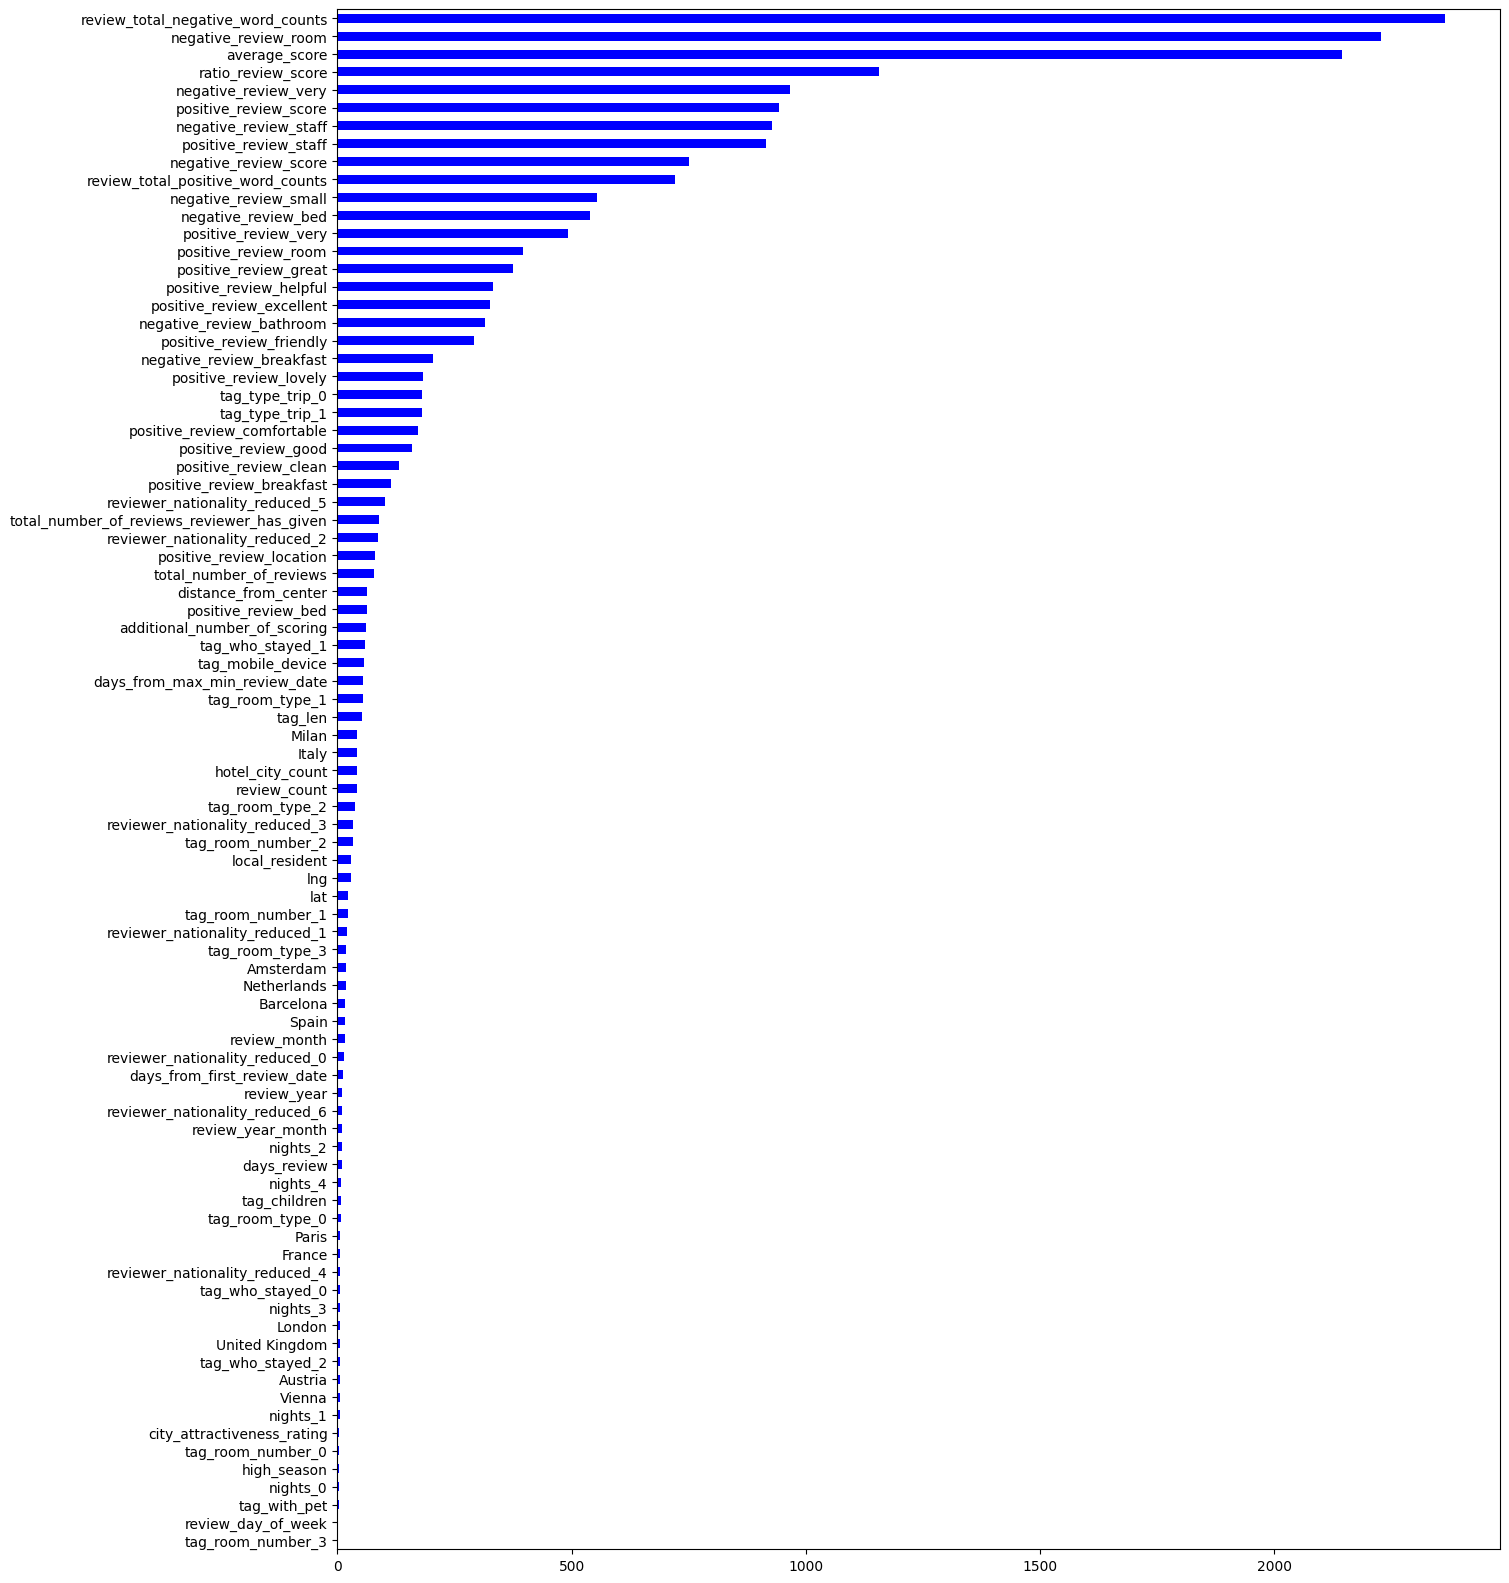

In [ ]:
# Для отбора признаков путем оценки информационного прироста каждой переменной в контексте целевой переменной (Information Gain, IG)
from sklearn.feature_selection import f_classif

# Подготавливаем данные для анализа
y = data.query('sample == 1').drop(['sample'], axis=1)['reviewer_score'].values
X = data.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)

# визуализируем результат анализа значимости:
imp_num = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
imp_num.sort_values(inplace = True)

fig5, ax5 = plt.subplots(figsize=(15, 20))
imp_num.plot(kind = 'barh', color='blue')

Отбираем признаки путем оценки информационного прироста каждой переменной в контексте целевой переменной, а также принимая в расчет полученную оценку с использованием метода Случайного Леса  (Random Forest Importance)

In [64]:
# Список признаков для удаления
#columns_to_drop = ['reviewer_nationality_reduced_5','tag_who_stayed_1','reviewer_nationality_reduced_2','nights_4','nights_3','reviewer_nationality_reduced_3','reviewer_nationality_reduced_6','tag_room_type_1','tag_room_number_2','tag_who_stayed_2','reviewer_nationality_reduced_4','tag_room_type_2','nights_2','reviewer_nationality_reduced_1','tag_who_stayed_0','tag_room_number_1','positive_review_breakfast','tag_room_number_3','tag_room_type_3','positive_review_clean','reviewer_nationality_reduced_0','positive_review_bed','review_year','nights_1','London','United Kingdom','Austria','Vienna','Milan','Italy','Amsterdam','Netherlands','Paris','tag_room_type_0','France','Barcelona','Spain','tag_with_pet','nights_0','tag_room_number_0']
#columns_to_drop = ['tag_who_stayed_1','nights_4','nights_3','tag_room_type_1','tag_room_number_2','tag_who_stayed_2','tag_room_type_2','nights_2','tag_who_stayed_0','tag_room_number_1','positive_review_breakfast','tag_room_number_3','tag_room_type_3','positive_review_clean','positive_review_bed','review_year','nights_1','London','United Kingdom','Austria','Vienna','Milan','Italy','Amsterdam','Netherlands','Paris','tag_room_type_0','France','Barcelona','Spain','tag_with_pet','nights_0','tag_room_number_0']
#columns_to_drop = ['nights_4','nights_3','tag_room_type_1','tag_room_number_2','tag_room_type_2','nights_2','tag_room_number_1','positive_review_breakfast','tag_room_number_3','tag_room_type_3','positive_review_clean','positive_review_bed','review_year','nights_1','London','United Kingdom','Austria','Vienna','Milan','Italy','Amsterdam','Netherlands','Paris','tag_room_type_0','France','Barcelona','Spain','tag_with_pet','nights_0','tag_room_number_0']
#columns_to_drop = ['nights_4','nights_3','tag_room_type_1','tag_room_number_2','tag_room_type_2','nights_2','tag_room_number_1','positive_review_breakfast','tag_room_number_3','tag_room_type_3','positive_review_clean','positive_review_bed','review_year','nights_1','London','United Kingdom','Austria','Vienna','Milan','Italy','Amsterdam','Netherlands','Paris','tag_room_type_0','France','Barcelona','Spain','tag_with_pet','nights_0','tag_room_number_0']
columns_to_drop = ['nights_4','nights_3','tag_room_type_1','tag_room_number_2','tag_room_type_2','nights_2','tag_room_number_1','tag_room_number_3','tag_room_type_3','review_year','nights_1','London','United Kingdom','Austria','Vienna','Milan','Italy','Amsterdam','Netherlands','Paris','tag_room_type_0','France','Barcelona','Spain','tag_with_pet','nights_0','tag_room_number_0']
#columns_to_drop = ['nights_4','nights_3','tag_room_type_1','tag_room_number_2','tag_room_type_2','nights_2','tag_room_number_1','tag_room_number_3','tag_room_type_3','review_year','nights_1','tag_room_type_0','tag_with_pet','nights_0','tag_room_number_0']
#columns_to_drop = ['tag_who_stayed_0','tag_who_stayed_1','tag_who_stayed_2','nights_4','nights_3','tag_room_type_1','tag_room_number_2','tag_room_type_2','nights_2','tag_room_number_1','tag_room_number_3','tag_room_type_3','review_year','nights_1','London','United Kingdom','Austria','Vienna','Milan','Italy','Amsterdam','Netherlands','Paris','tag_room_type_0','France','Barcelona','Spain','tag_with_pet','nights_0','tag_room_number_0']
#columns_to_drop = ['nights_4','nights_3','tag_room_number_2','nights_2','tag_room_number_1','tag_room_number_3','review_year','nights_1','London','United Kingdom','Austria','Vienna','Amsterdam','Netherlands','Paris','France','Barcelona','Spain','tag_with_pet','nights_0','tag_room_number_0']
# Удалить признаки из DataFrame
data = data.drop(columns_to_drop, axis=1)

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515504 entries, 0 to 515503
Data columns (total 61 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515504 non-null  int64  
 1   average_score                               515504 non-null  float64
 2   review_total_negative_word_counts           515504 non-null  int64  
 3   total_number_of_reviews                     515504 non-null  int64  
 4   review_total_positive_word_counts           515504 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515504 non-null  int64  
 6   lat                                         515504 non-null  float64
 7   lng                                         515504 non-null  float64
 8   sample                                      515504 non-null  int64  
 9   reviewer_score                              515504 non-null  float64
 

In [66]:
#columns_to_drop = ['review_day_of_week','high_season','city_attractiveness_rating','positive_review_lovely','positive_review_helpful','positive_review_comfortable','positive_review_friendly','positive_review_bed','positive_review_excellent','positive_review_great']
columns_to_drop = ['review_day_of_week','high_season','city_attractiveness_rating']
#columns_to_drop = ['high_season','city_attractiveness_rating']
#columns_to_drop = ['review_day_of_week','high_season','city_attractiveness_rating','negative_review_score']
#columns_to_drop = ['review_day_of_week','high_season','city_attractiveness_rating','negative_review_score','positive_review_score']
data = data.drop(columns_to_drop, axis=1)

<Axes: >

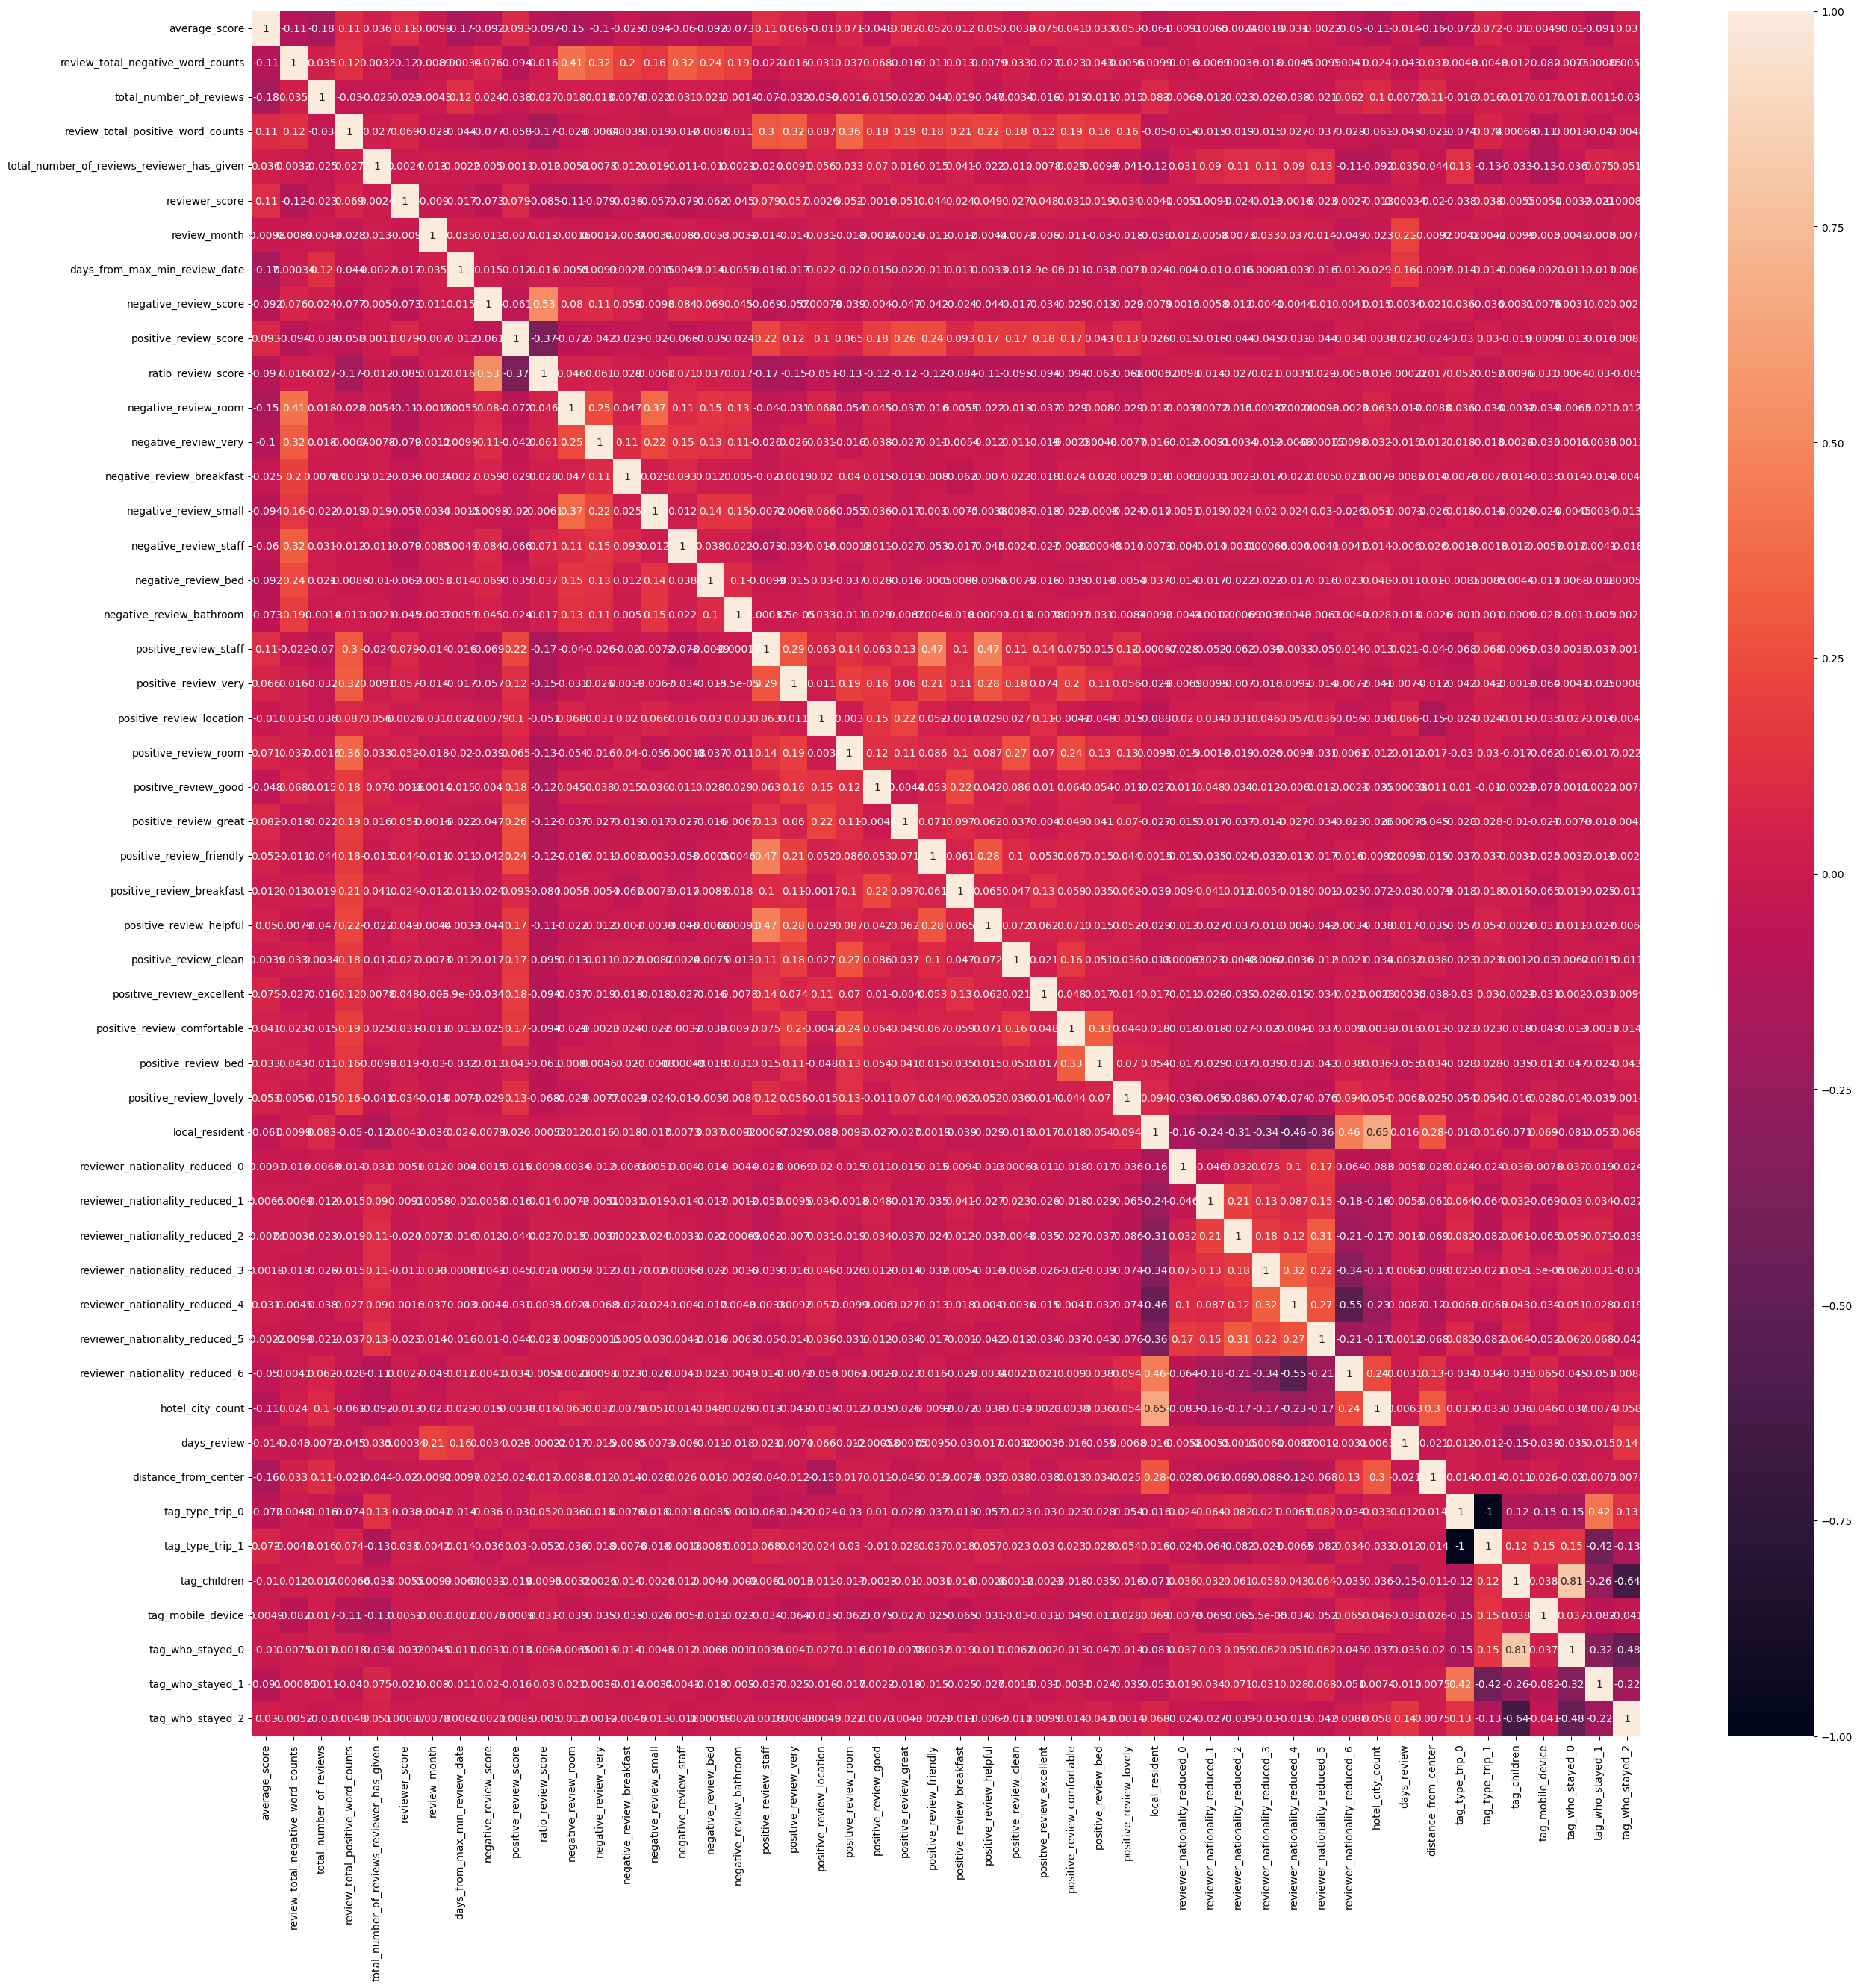

In [80]:
# Строим heatmap и определяем корреляцию между признаками
plt.rcParams['figure.figsize'] = (30,30)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

Удаляем сильно скореллированные признаки

In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515504 entries, 0 to 515503
Data columns (total 51 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515504 non-null  float64
 1   review_total_negative_word_counts           515504 non-null  int64  
 2   total_number_of_reviews                     515504 non-null  int64  
 3   review_total_positive_word_counts           515504 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515504 non-null  int64  
 5   sample                                      515504 non-null  int64  
 6   reviewer_score                              515504 non-null  float64
 7   review_month                                515504 non-null  int32  
 8   days_from_max_min_review_date               515504 non-null  int64  
 9   negative_review_score                       515504 non-null  float64
 

In [81]:
# Список признаков для удаления
#columns_to_drop = ['additional_number_of_scoring','review_count','days_from_first_review_date','review_year_month','tag_len','lng','lat','tag_children']
columns_to_drop = ['additional_number_of_scoring','review_count','days_from_first_review_date','review_year_month','tag_len','lng','lat','tag_type_trip_1']
#columns_to_drop = ['additional_number_of_scoring','review_count','days_from_first_review_date','tag_len','lng','lat']
#columns_to_drop = ['additional_number_of_scoring','review_count','days_from_first_review_date','review_year_month','tag_len','tag_children']
# Удалить признаки из DataFrame
data = data.drop(columns_to_drop, axis=1)

KeyError: "['additional_number_of_scoring', 'review_count', 'days_from_first_review_date', 'review_year_month', 'tag_len', 'lng', 'lat'] not found in axis"

## Анализ распределения
Строил графики, а также логорифмировал все числовые признаки, но результат только ухудшается. Убрал этот блок

# Построение модели

In [83]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  

# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [84]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

In [85]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 50), (386569, 50), (386569, 49), (289926, 49), (96643, 49))

In [86]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [87]:
# Создаём модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [88]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


In [89]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12394626807776361


<Axes: >

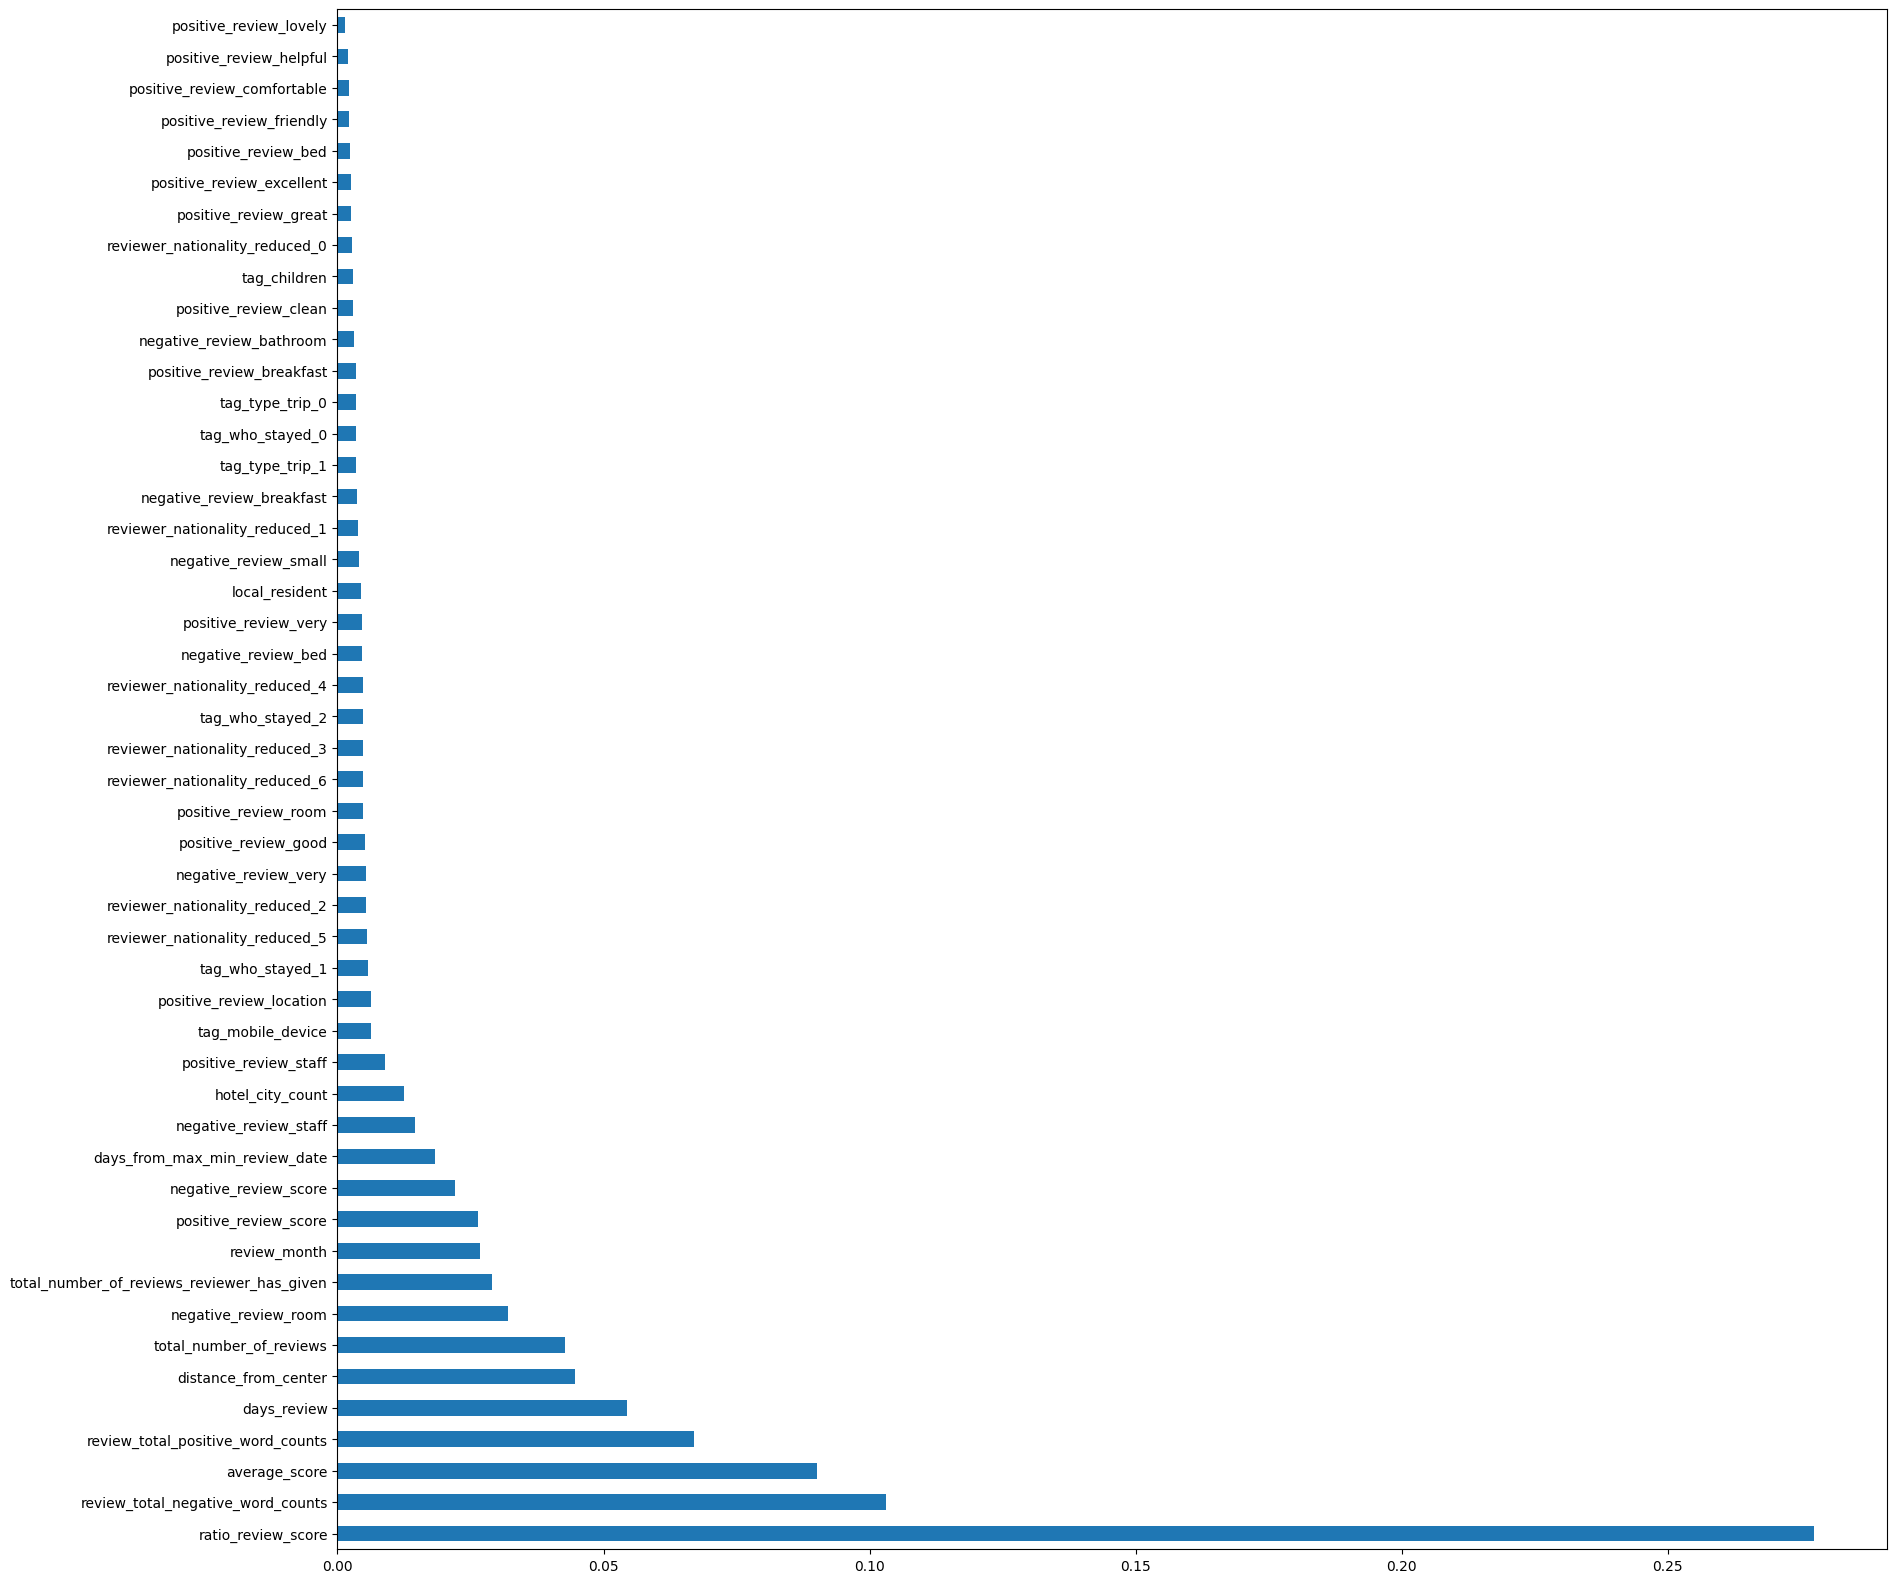

In [90]:
# в RandomForestRegressor есть возможность вывести самые важные признаки
plt.rcParams['figure.figsize'] = (20,20)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(90).plot(kind='barh')

In [91]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [92]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.0s finished


In [93]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.863,488440
1,7.416,274649
2,8.439,374688
3,9.623,404352
4,9.718,451596
5,8.581,302161
6,7.530,317079
7,7.488,13963
8,8.744,159785
9,7.908,195089
